In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier

warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)

In [8]:
# 1. 데이터 불러오기
df = pd.read_csv("/content/건강검진 (1).csv")

In [10]:
df

,YEAR,ID,SEX,AGE_GROUP,SIDO,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,BMI,OBESITY,DYSLIPIDEMIA,DIABETES,HYPERTENSION,LIVER_ABNORMAL,KIDNEY_ABNORMAL,ANEMIA
0,2017,1,1,8,43,170,75,90.0,120,80,99,193.0,92.0,48.0,126.0,17.1,1,1.0,21.0,35.0,40.0,1,1,26.0,class1,False,normal,pre,False,False,False
1,2017,2,1,7,11,180,80,89.0,130,82,106,228.0,121.0,55.0,148.0,15.8,1,0.9,20.0,36.0,27.0,3,0,24.7,pre,False,pre,pre,False,False,False
2,2017,3,1,9,41,165,75,91.0,120,70,98,136.0,104.0,41.0,74.0,15.8,1,0.9,47.0,32.0,68.0,1,0,27.5,class1,False,normal,pre,True,False,False
3,2017,4,1,11,48,175,80,91.0,145,87,95,201.0,106.0,76.0,104.0,17.6,1,1.1,29.0,34.0,18.0,1,0,26.1,class1,False,normal,stage1,False,False,False
4,2017,5,1,11,30,165,60,80.0,138,82,101,199.0,104.0,61.0,117.0,13.8,1,0.8,19.0,12.0,25.0,1,0,22.0,normal,False,pre,pre,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386508,2022,2134210,1,6,43,170,90,98.8,128,84,88,245.0,150.0,35.0,180.0,15.8,1,0.9,95.0,251.0,77.0,1,1,31.1,class2,True,normal,pre,True,False,False
2386509,2022,1686113,2,15,27,150,85,116.0,136,81,134,240.0,108.0,73.0,145.0,12.4,1,1.4,59.0,49.0,25.0,1,0,37.8,class3,True,diabetes,pre,True,False,False
2386510,2022,902951,1,12,45,165,80,98.2,119,83,181,205.0,191.0,47.0,120.0,15.7,1,1.0,48.0,82.0,60.0,2,1,29.4,class1,False,diabetes,pre,True,False,False
2386511,2022,3721315,1,6,47,175,65,75.4,109,60,91,178.0,61.0,54.0,112.0,13.7,1,1.1,245.0,72.0,17.0,2,1,21.2,normal,False,normal,normal,True,False,False


In [14]:
df["Year_ID"] = df["YEAR"].astype(str) + "_" + df["ID"].astype(str)
cols = ['Year_ID'] + [col for col in df.columns if col != 'Year_ID']
df = df[cols]
df = df.drop(['ID', 'YEAR'], axis=1)

In [18]:
# 2. 라벨 맵핑
df['OBESITY'] = df['OBESITY'].map({'normal': 0, 'pre': 1, 'class1': 2, 'class2': 3, 'class3': 4})
df['DIABETES'] = df['DIABETES'].map({'normal': 0, 'pre': 1, 'diabetes': 2})
df['HYPERTENSION'] = df['HYPERTENSION'].map({'normal': 0, 'pre': 1, 'stage1': 2, 'stage2': 3})
binary_cols = ['DYSLIPIDEMIA', 'LIVER_ABNORMAL', 'KIDNEY_ABNORMAL', 'ANEMIA']
for col in binary_cols:
    df[col] = df[col].map({False: 0, True: 1})

In [5]:
df.head()

,Year_ID,SEX,AGE_GROUP,SIDO,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,BMI,OBESITY,DYSLIPIDEMIA,DIABETES,HYPERTENSION,LIVER_ABNORMAL,KIDNEY_ABNORMAL,ANEMIA
0,2017_1,1.0,8.0,43.0,170.0,75.0,90.0,120.0,80.0,99.0,193.0,92.0,48.0,126.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1.0,26.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2017_2,1.0,7.0,11.0,180.0,80.0,89.0,130.0,82.0,106.0,228.0,121.0,55.0,148.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0.0,24.7,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,2017_3,1.0,9.0,41.0,165.0,75.0,91.0,120.0,70.0,98.0,136.0,104.0,41.0,74.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0.0,27.5,2.0,0.0,0.0,1.0,1.0,0.0,0.0
3,2017_4,1.0,11.0,48.0,175.0,80.0,91.0,145.0,87.0,95.0,201.0,106.0,76.0,104.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0.0,26.1,2.0,0.0,0.0,2.0,0.0,0.0,0.0
4,2017_5,1.0,11.0,30.0,165.0,60.0,80.0,138.0,82.0,101.0,199.0,104.0,61.0,117.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0.0,22.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [16]:
df.isnull().sum()

,0
Year_ID,0
SEX,0
AGE_GROUP,0
SIDO,0
HEIGHT,0
WEIGHT,0
WAIST,0
BP_HIGH,0
BP_LWST,0
BLDS,0


새로운 환자의 건강 정보를 입력받아 그 환자의 비만도를 예측

 학습에 사용했던 것과 동일한 순서와 전처리 방식으로 새로운 환자의 특성 데이터를 준비하여 모델에 입력하면, 모델은 해당 환자가 5가지 비만 범주 중 어디에 속할 가능성이 가장 높은지 예측 결과를 반환

In [17]:
# 3. 입력 변수 정의 및 정규화
input_features = ["HEIGHT", "WEIGHT", "WAIST", "BP_HIGH", "BP_LWST",
                  "BLDS", "TOT_CHOLE", "TRIGLYCERIDE", "HDL_CHOLE",
                  "LDL_CHOLE", "HMG", "OLIG_PROTE_CD", "CREATININE",
                  "SGOT_AST", "SGPT_ALT", "GAMMA_GTP", "SMK_STAT_TYPE_CD",
                  "DRK_YN", "BMI"]

scaler = RobustScaler()
df[input_features] = scaler.fit_transform(df[input_features])

In [18]:
#<XGBoost>
# 4. 타겟 분리 및 BMI 제거
target = 'OBESITY'
X = df.drop(columns=[target, 'BMI', 'WEIGHT','Year_ID'])

scaler = StandardScaler()
X= scaler.fit_transform(X)
Y = df[target]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

# 9. XGBoost 학습 및 예측
model = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)


In [19]:
# 10. 성능 평가
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

Confusion Matrix:
[[165243  18743  14261     28      5]
 [ 30889  31182  30964     59      3]
 [ 15466  18030 122274   4208     49]
 [    61    147  11879   9590    637]
 [     5      3    349   1688   1540]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81    198280
           1       0.46      0.33      0.39     93097
           2       0.68      0.76      0.72    160027
           3       0.62      0.43      0.51     22314
           4       0.69      0.43      0.53      3585

    accuracy                           0.69    477303
   macro avg       0.64      0.56      0.59    477303
weighted avg       0.68      0.69      0.68    477303



클래스 0 예측 good
클래스 1 예측 bad (높은 false positive와 낮은 recall이 문제)
클래스 2 so so
클래스 3 too bad (특히 recall이 낮음)
클래스 4 클래스 수가 너무 작음

In [20]:
print(df["OBESITY"].value_counts())

OBESITY
0    989724
2    799269
1    467218
3    112755
4     17547
Name: count, dtype: int64


In [ ]:
#<XGBoost+SMOTE> - 클래스 균형 맞추기
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb

# 데이터 준비
X = df.drop(["OBESITY", 'BMI', 'WEIGHT','Year_ID'], axis=1)
y = df["OBESITY"]

# SMOTE 적용하여 클래스 불균형 해결
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, scale_pos_weight=[class_weights[i] for i in range(5)])
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


전보다 개선됨.

In [ ]:
#<lightGBM + SMOTE>
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# 특성과 타겟 설정
X = df.drop(["OBESITY", "BMI", "WEIGHT","Year_ID"], axis=1)
y = df["OBESITY"]

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# LightGBM 모델 학습
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    class_weight='balanced',  # 불균형 대응
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4394
[LightGBM] [Info] Number of data points in the train set: 3958896, number of used features: 26
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    197945
           1       0.67      0.68      0.68    197944
           2       0.67      0.64      0.65    197945
           3       0.76      0.76      0.76    197945
           4       0.86      0.85      0.86    197945

    accuracy                           0.75    98

In [ ]:
#<lightGBM + SMOTE + features importance 낮은 변수들 제거>
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
targets = ['OBESITY','DYSLIPIDEMIA','DIABETES','HYPERTENSION','LIVER_ABNORMAL','KIDNEY_ABNORMAL','ANEMIA']
# 특성과 타겟 설정
X = df.drop(columns=targets + ['BMI',"WEIGHT",'Year_ID'])
y = df["OBESITY"]

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# LightGBM 모델 학습
lgbm_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    class_weight='balanced',  # 불균형 대응
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4378
[LightGBM] [Info] Number of data points in the train set: 3958896, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    197945
           1       0.67      0.68      0.68    197944
           2       0.67      0.64      0.65    197945
           3       0.75      0.76      0.76    197945
           4       0.86      0.85      0.85    197945

    accuracy                           0.75    98

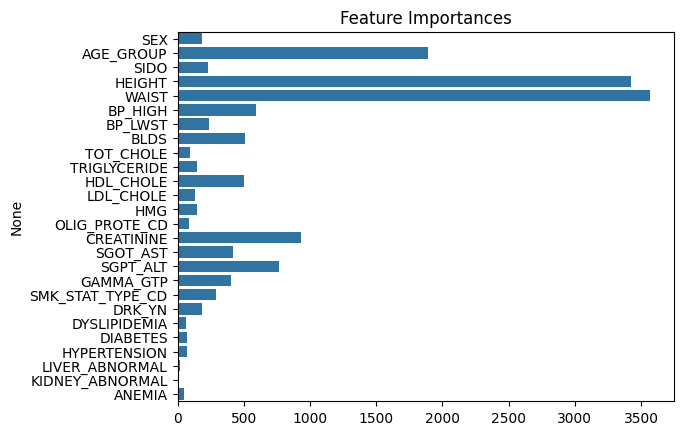

In [ ]:
sns.barplot(
    x=lgbm_model.feature_importances_,
    y=X.columns
)
plt.title("Feature Importances")
plt.show()


각 질병 별 상관계수와 feature imprtances 확인해야 할 듯.

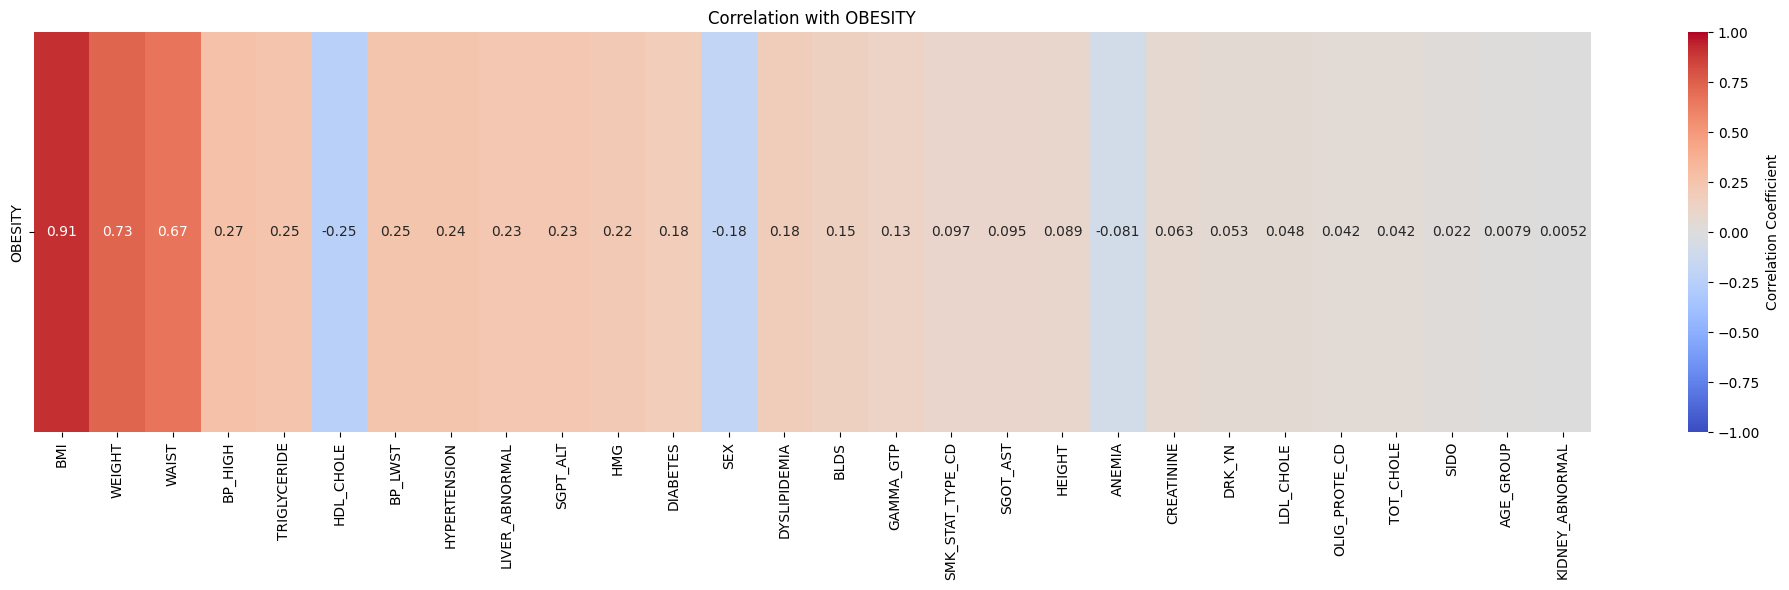

In [ ]:
#OBESITY 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# OBESITY 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["OBESITY"]].drop("OBESITY").sort_values(by="OBESITY", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with OBESITY")
plt.tight_layout()
plt.show()


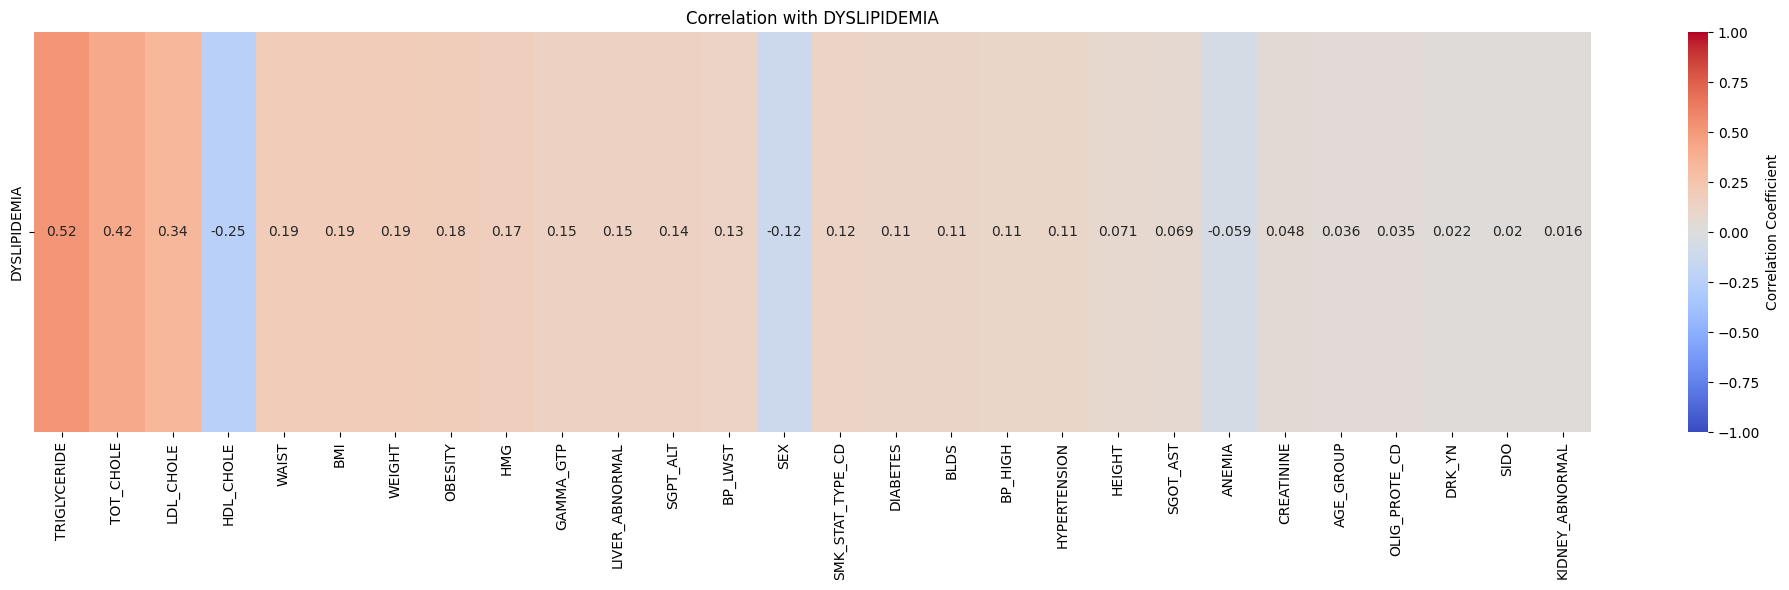

In [ ]:
#DYSLIPIDEMIA 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# DYSLIPIDEMIA와 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["DYSLIPIDEMIA"]].drop("DYSLIPIDEMIA").sort_values(by="DYSLIPIDEMIA", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with DYSLIPIDEMIA")
plt.tight_layout()
plt.show()


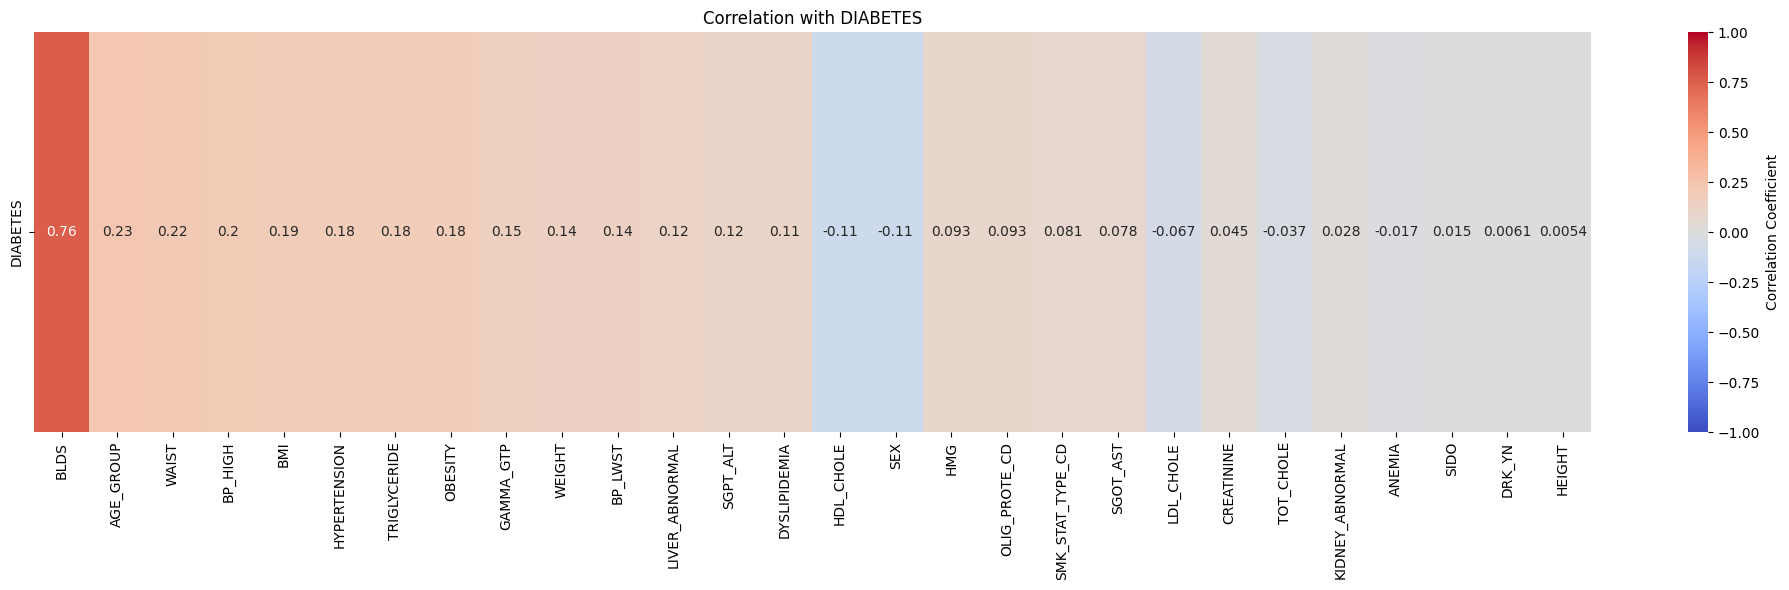

In [ ]:
#DIABETES 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# DIABETES 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["DIABETES"]].drop("DIABETES").sort_values(by="DIABETES", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with DIABETES")
plt.tight_layout()
plt.show()


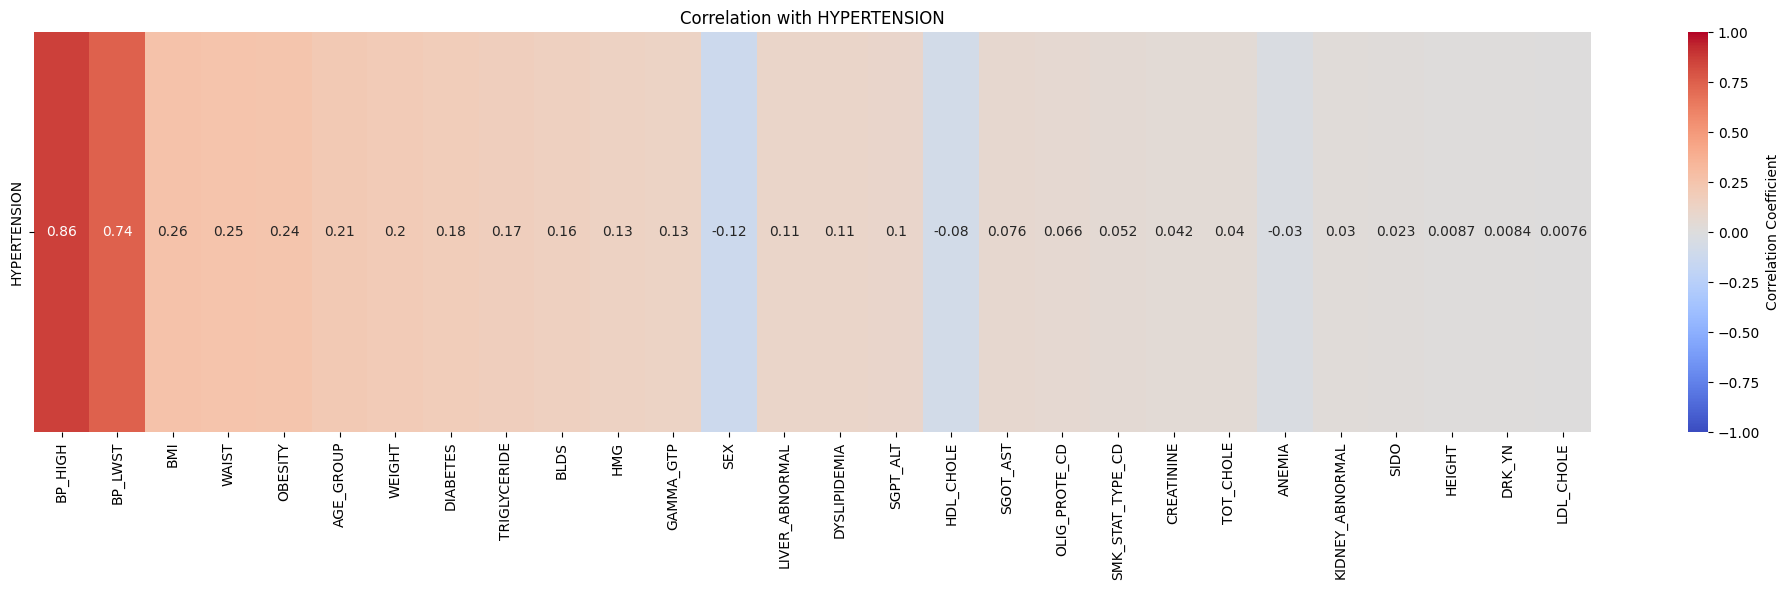

In [ ]:
#HYPERTENSION 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# HYPERTENSION 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["HYPERTENSION"]].drop("HYPERTENSION").sort_values(by="HYPERTENSION", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with HYPERTENSION")
plt.tight_layout()
plt.show()


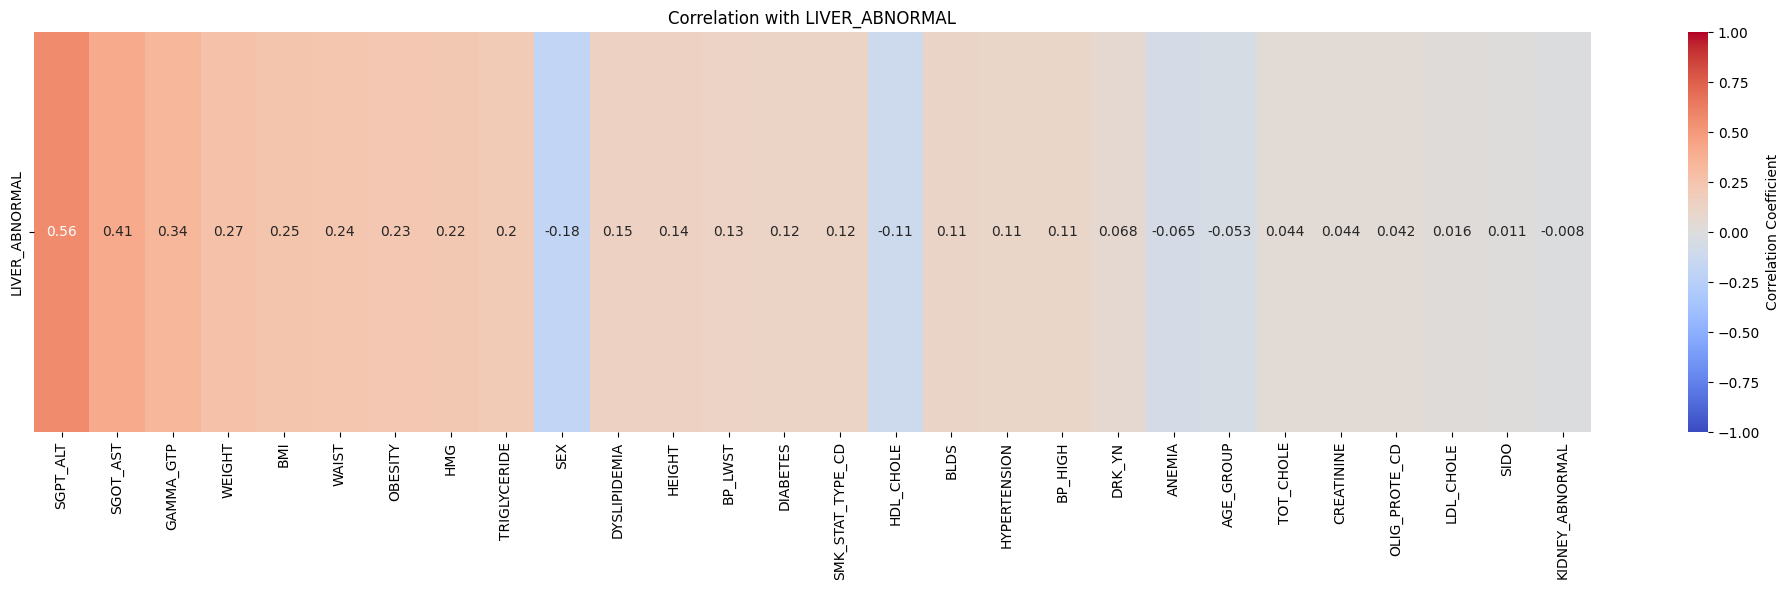

In [ ]:
#LIVER_ABNORMAL 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# LIVER_ABNORMAL 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["LIVER_ABNORMAL"]].drop("LIVER_ABNORMAL").sort_values(by="LIVER_ABNORMAL", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with LIVER_ABNORMAL")
plt.tight_layout()
plt.show()


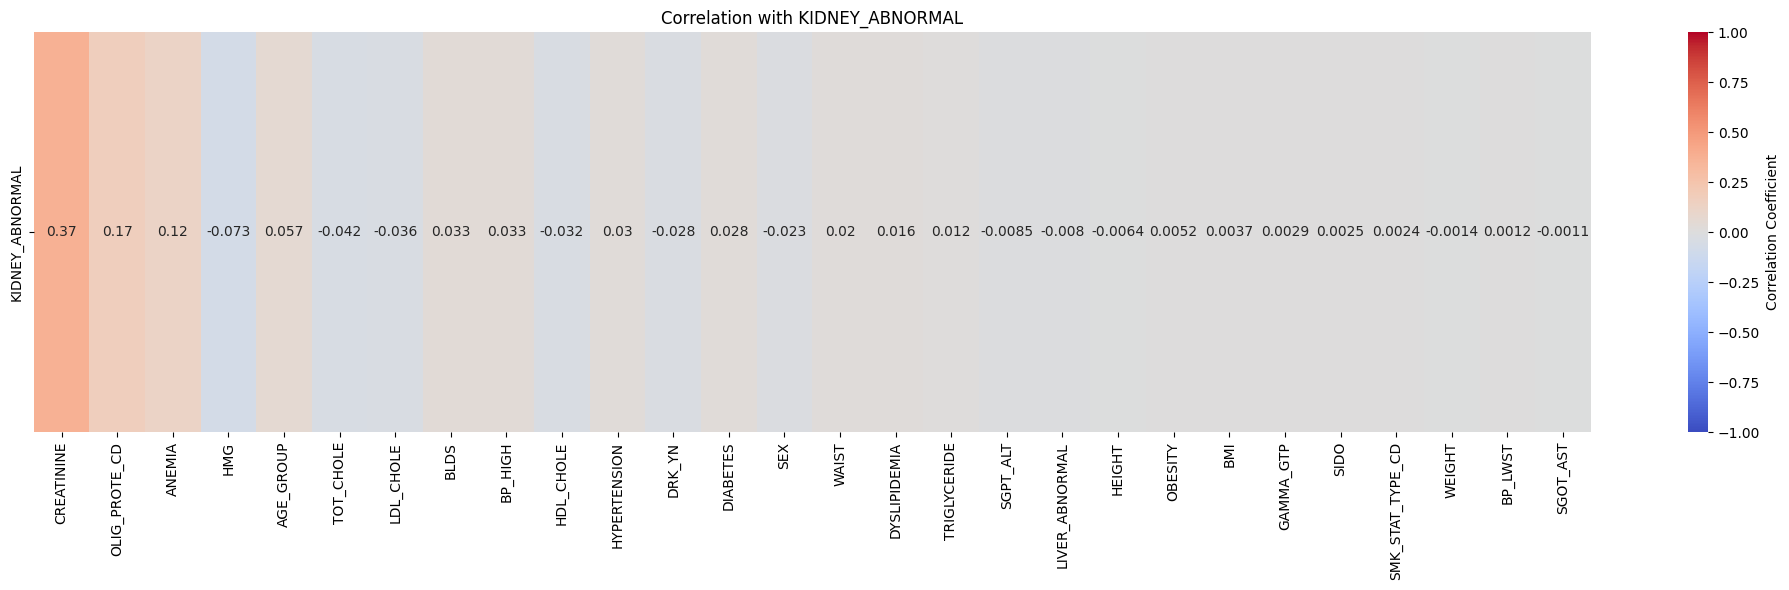

In [ ]:
#KIDNEY_ABNORMAL 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# KIDNEY_ABNORMAL 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["KIDNEY_ABNORMAL"]].drop("KIDNEY_ABNORMAL").sort_values(by="KIDNEY_ABNORMAL", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with KIDNEY_ABNORMAL")
plt.tight_layout()
plt.show()


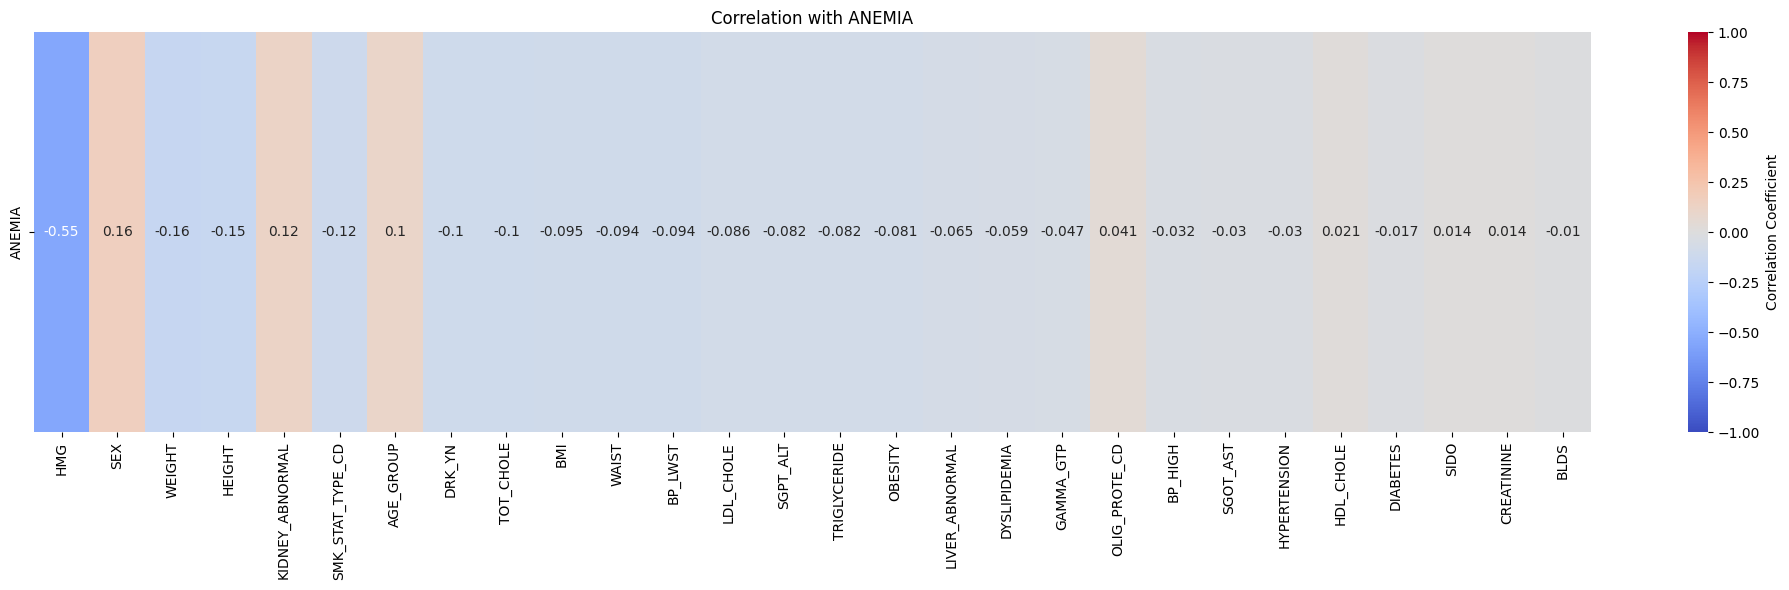

In [ ]:
#ANEMIA 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df.corr(numeric_only=True)

# ANEMIA 다른 변수들 간의 상관관계 추출
corr_with_target = corr_matrix[["ANEMIA"]].drop("ANEMIA").sort_values(by="ANEMIA", key=abs, ascending=False)

# 히트맵 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_with_target.T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation with ANEMIA")
plt.tight_layout()
plt.show()


# Task


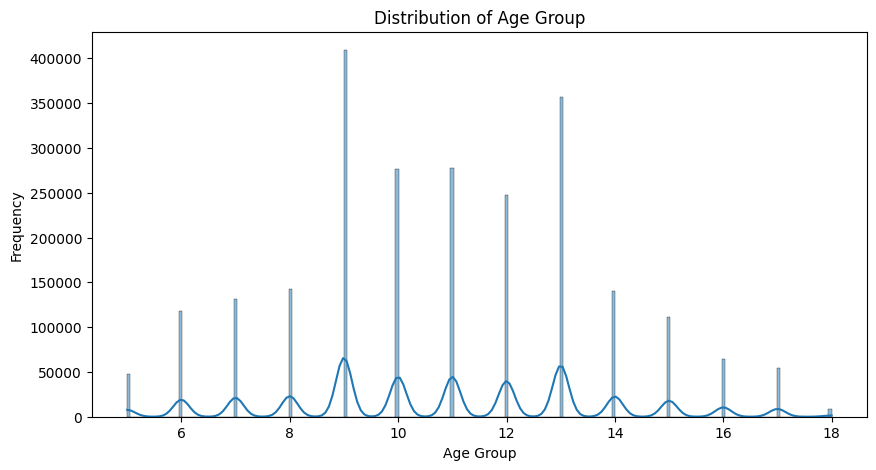

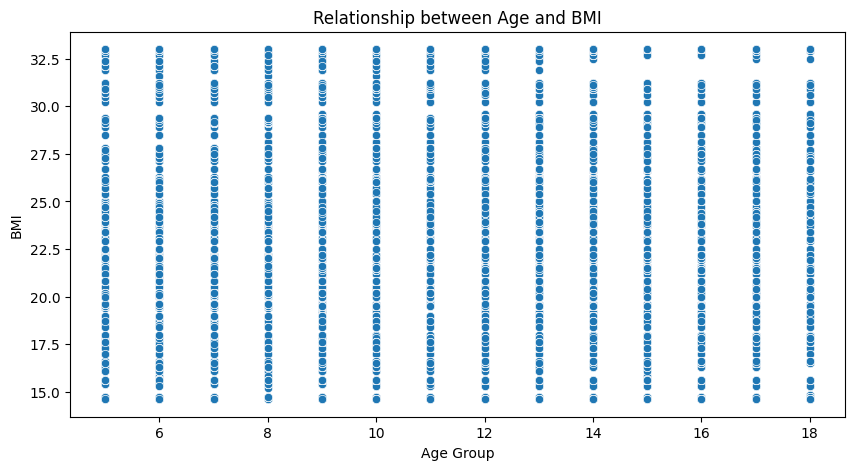

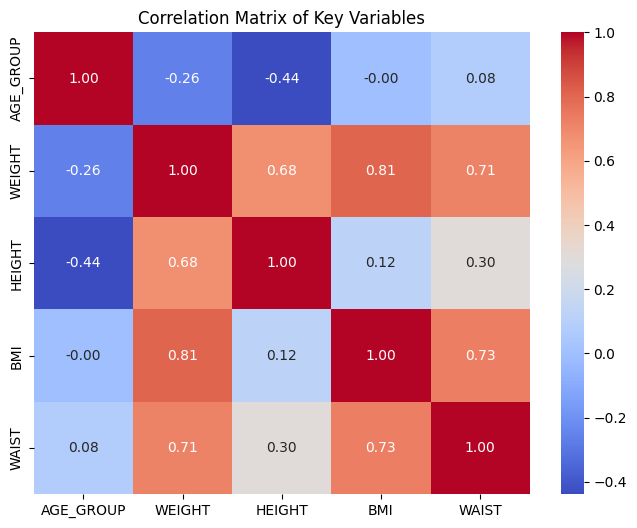

In [10]:
# 나이 별 데이터
plt.figure(figsize=(10, 5))
sns.histplot(df['AGE_GROUP'], kde=True)
plt.title('Distribution of Age Group')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()

# bmi와 나이 그룹: 특징은 안 보임
plt.figure(figsize=(10, 5))
sns.scatterplot(x='AGE_GROUP', y='BMI', data=df)
plt.title('Relationship between Age and BMI')
plt.xlabel('Age Group')
plt.ylabel('BMI')
plt.show()

# Correlation analysis
correlation_matrix = df[['AGE_GROUP', 'WEIGHT', 'HEIGHT', 'BMI', 'WAIST']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Variables')
plt.show()

#최적의 k는 이너샤 값이 급격하게 감소하다가 완만하게 감소하는 '엘보우' 지점으로 판단

In [ ]:
#각 연령별 군집화...

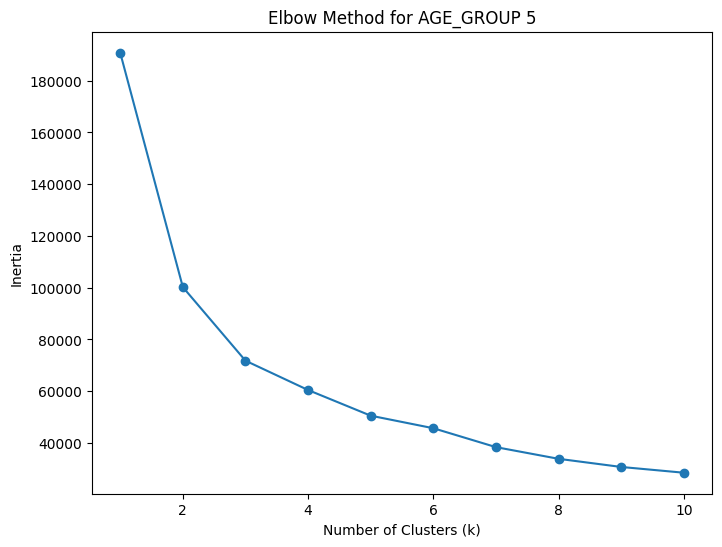

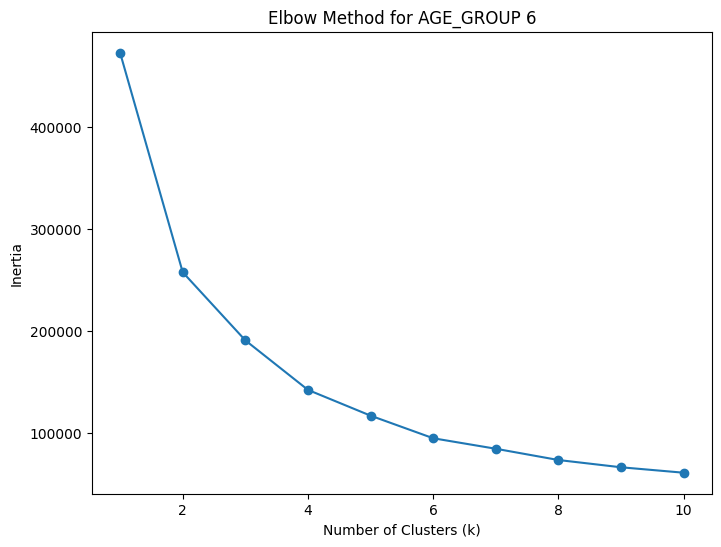

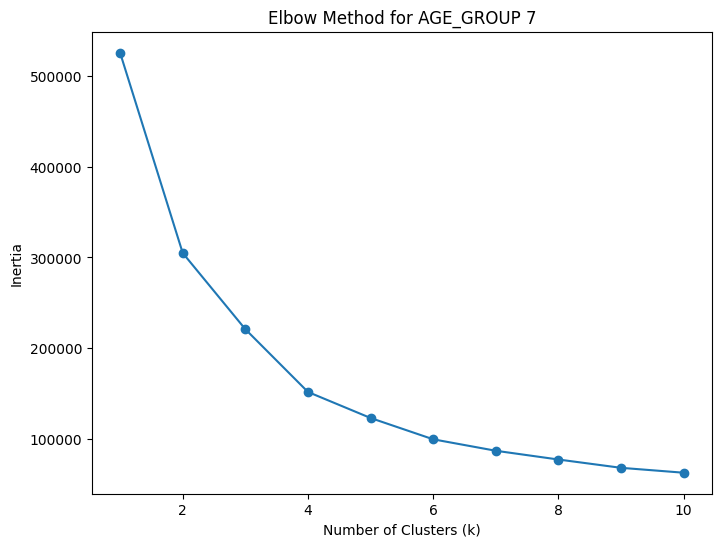

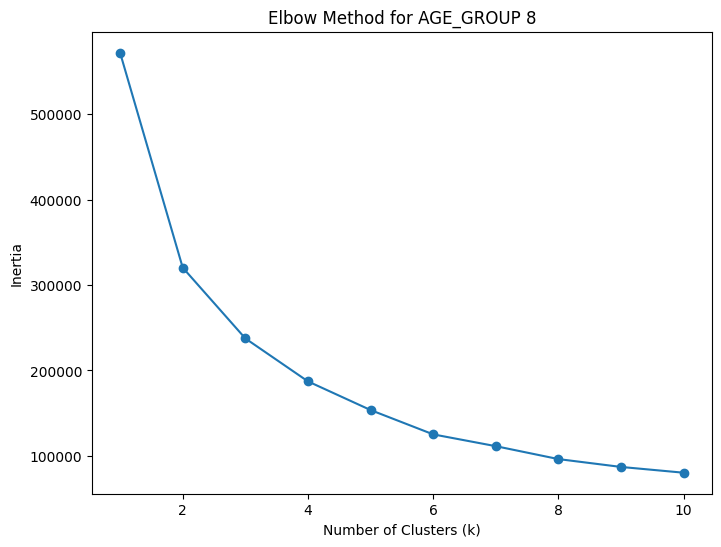

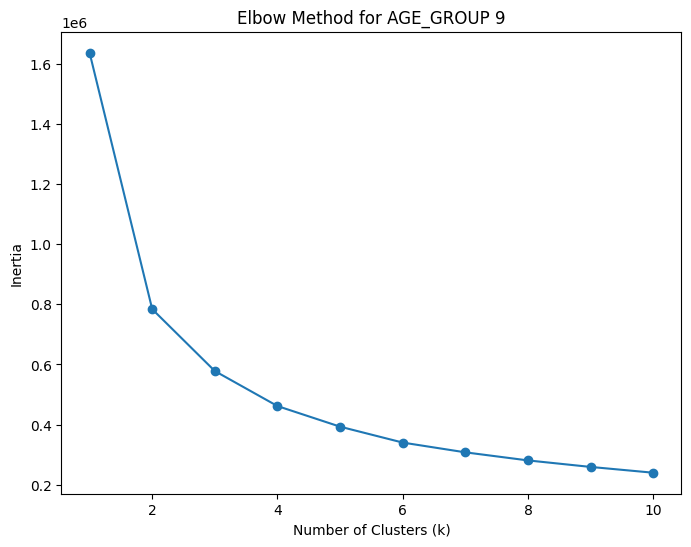

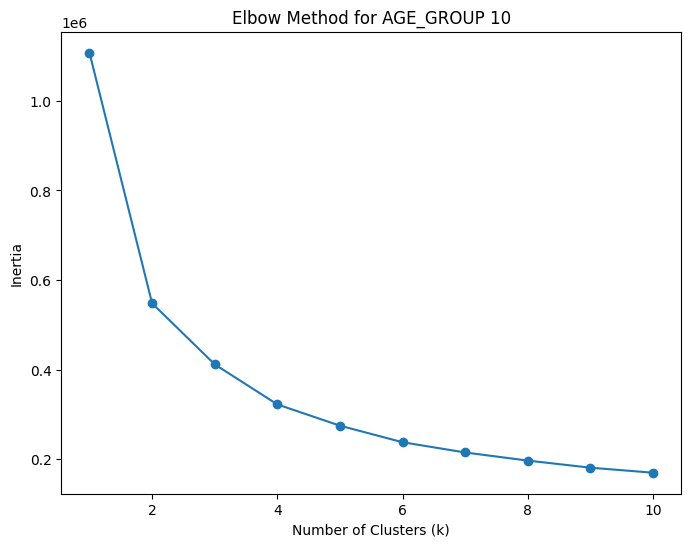

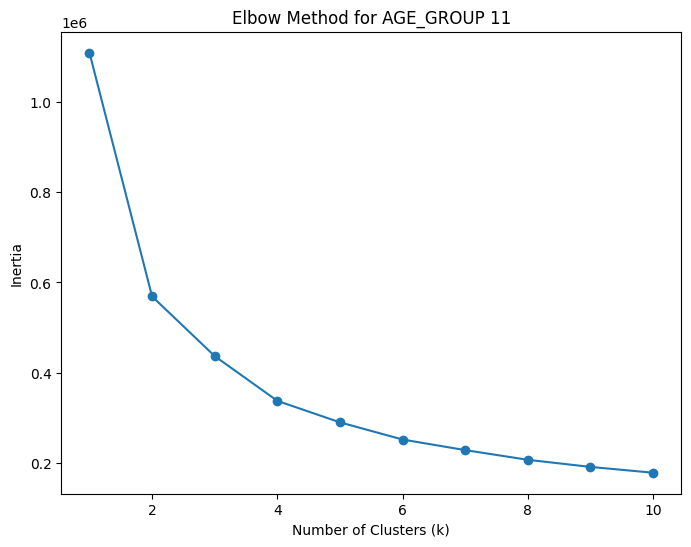

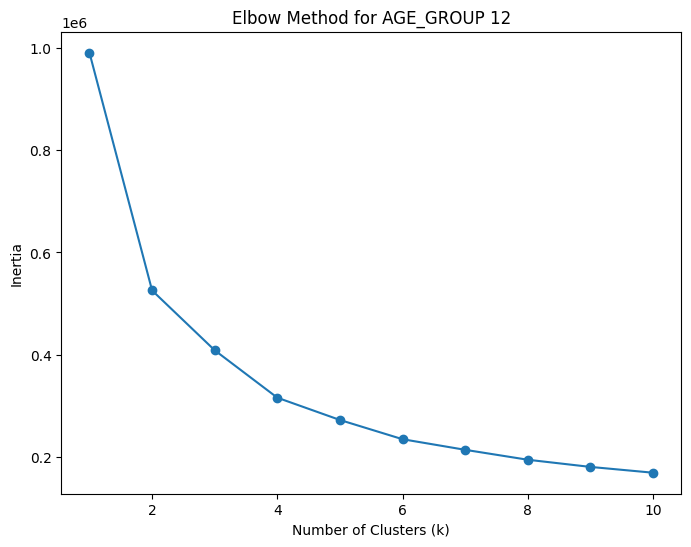

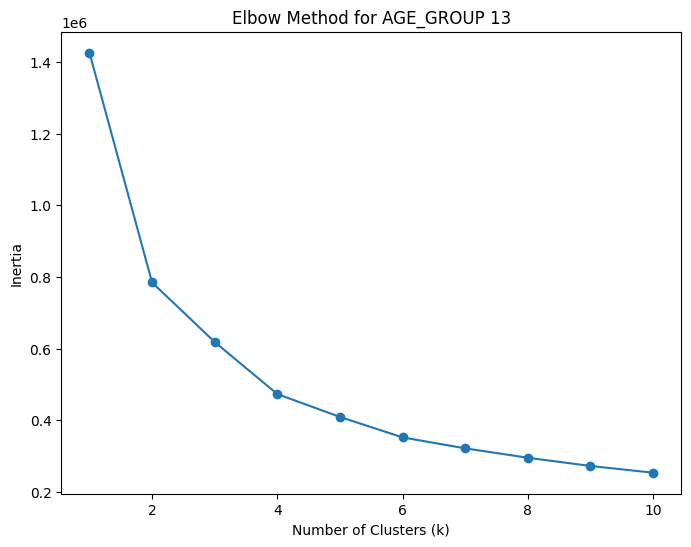

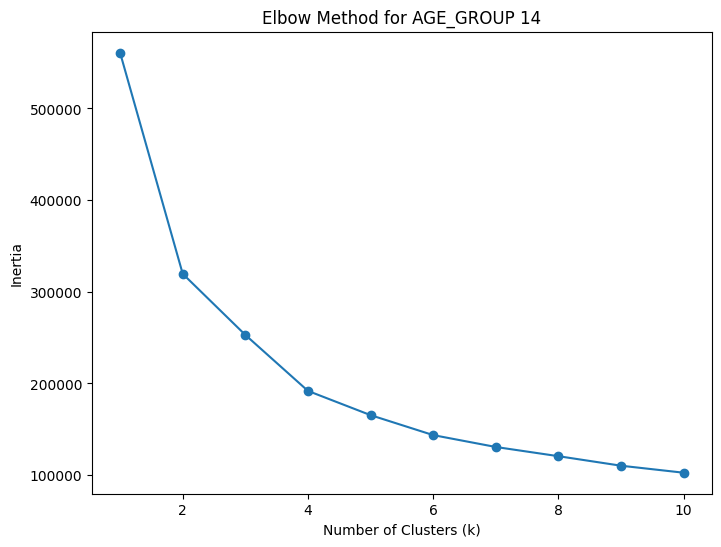

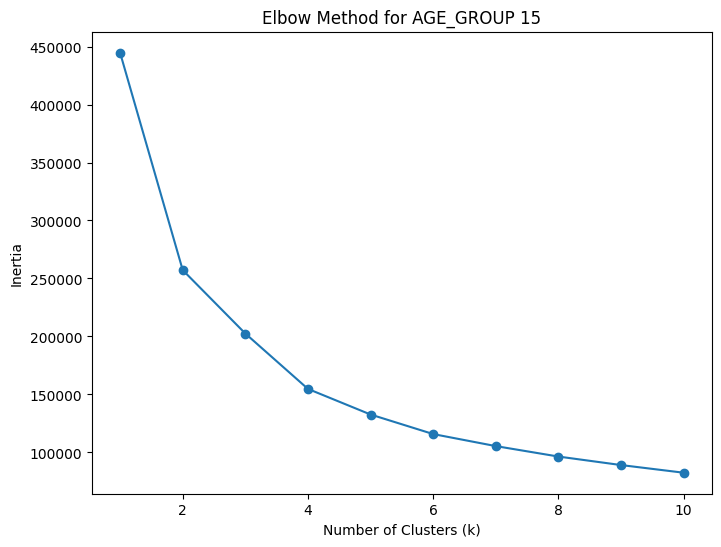

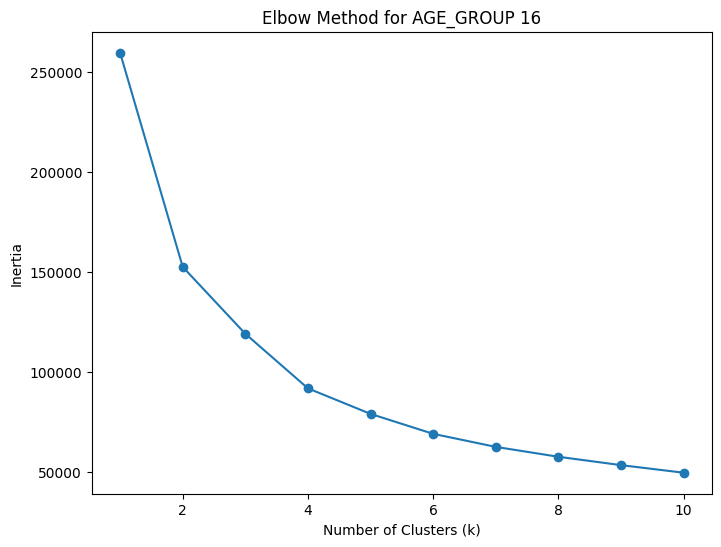

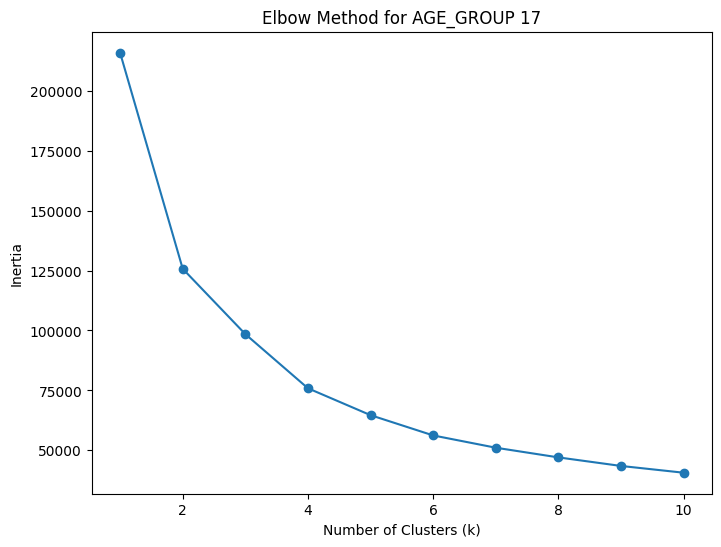

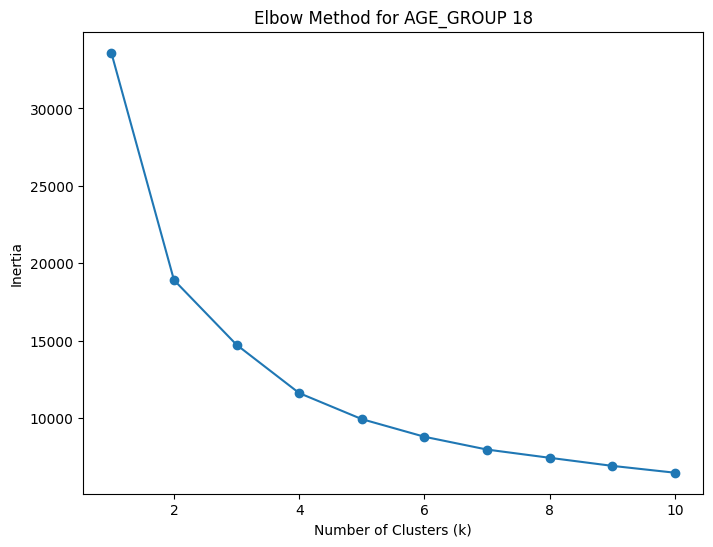

<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# 데이터프레임 df가 이미 정의되어 있다고 가정합니다.

# AGE 그룹별 데이터 그룹화
age_groups = df.groupby('AGE_GROUP')

# 시각화 결과 저장 리스트
results_df = []
all_inertia = {}

for age_group, data in age_groups:
    # 군집화에 사용할 특징
    features = ['BMI', 'WAIST', 'WEIGHT', 'HEIGHT']
    X = data[features].dropna()

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 최적의 k 찾기 (엘보우 메서드)
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    all_inertia[age_group] = inertia

    # 엘보우 플롯 (각 연령대별로 표시)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title(f'Elbow Method for AGE_GROUP {age_group}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()


    optimal_k_values = {
        data['AGE_GROUP'].iloc[0]: np.random.randint(2, 5)
        for age in data['AGE_GROUP'].unique()
    }
    optimal_k = optimal_k_values.get(age_group, 3) # 기본값 3

    # KMeans 군집화 적용 (최적의 k 사용)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    data['cluster'] = clusters
    results_df.append(data)

df_clustered = pd.concat(results_df)

plt.tight_layout()
plt.show()

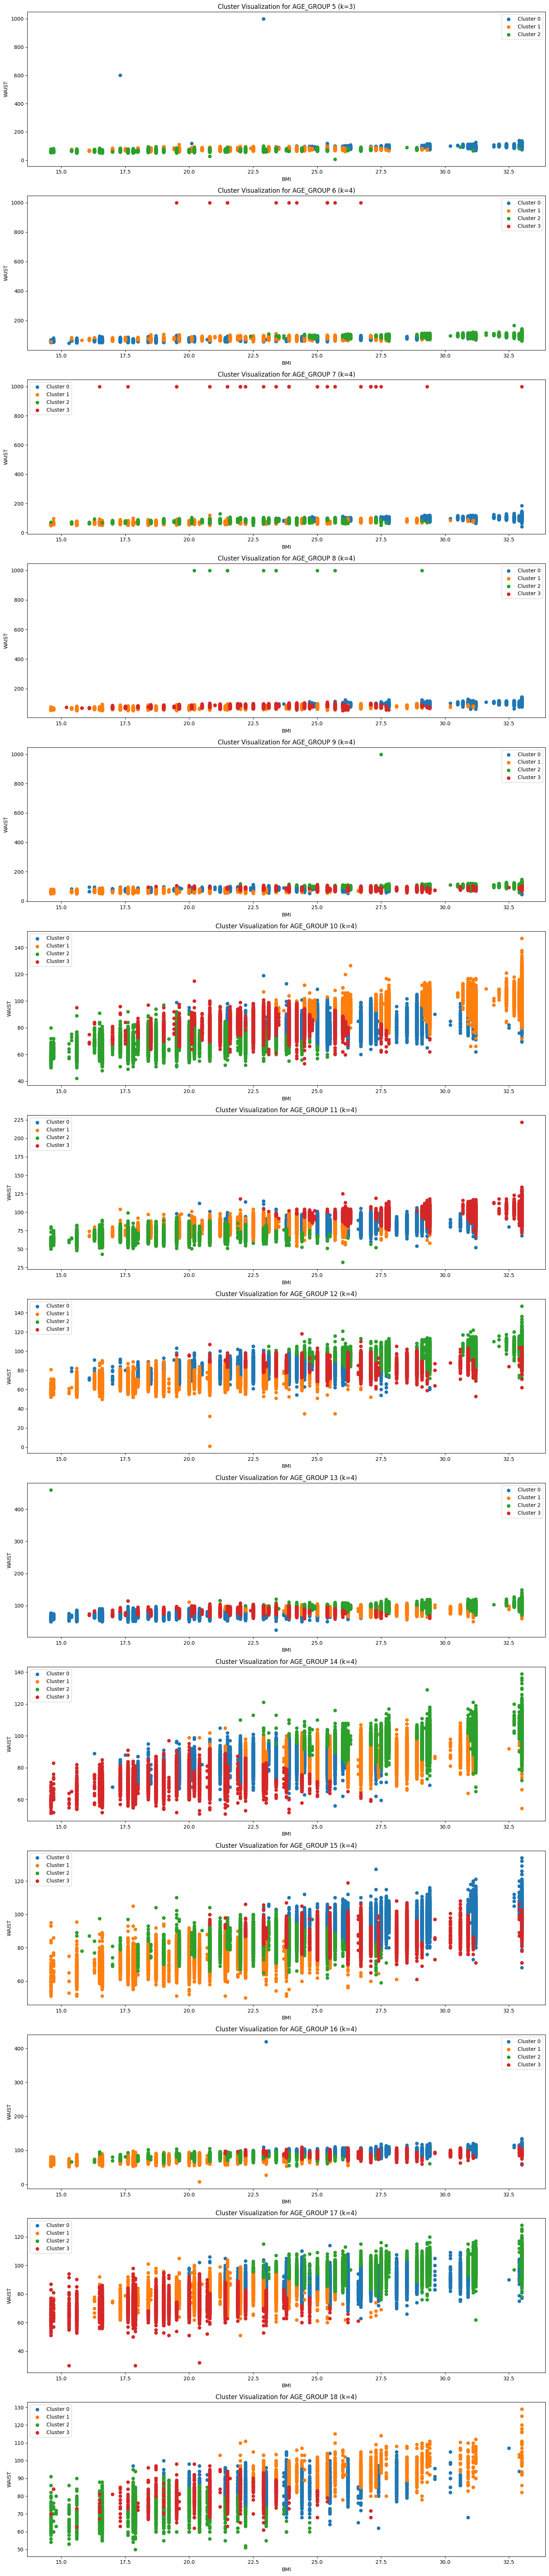

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 데이터프레임 df가 이미 정의되어 있다고 가정합니다.

# 각 연령대에 대한 사용자가 지정한 최적 k 값 리스트 (연령대 순서대로)
# 실제 연령대 순서와 개수에 맞춰 k 값을 지정해야 합니다.
user_defined_k_values = {
    1: 3,  # AGE_GROUP 1에 대한 최적 k 값
    2: 4,  # AGE_GROUP 2에 대한 최적 k 값
    3: 2,  # AGE_GROUP 3에 대한 최적 k 값
    4: 3,  # AGE_GROUP 4에 대한 최적 k 값
    5: 3,  # AGE_GROUP 5에 대한 최적 k 값
    6: 4,
    7: 4,
    8: 4,
    9: 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
    15: 4,
    16: 4,
    17: 4,
    18: 4
}

# AGE 그룹별 데이터 그룹화
age_groups = df.groupby('AGE_GROUP')

# 시각화 결과 저장 리스트
results_df = []

for age_group, data in age_groups:
    # 군집화에 사용할 특징
    features = ['BMI', 'WAIST', 'WEIGHT', 'HEIGHT']
    X = data[features].dropna()

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 사용자가 지정한 최적 k 값 가져오기
    optimal_k = user_defined_k_values.get(age_group, 3)  # 해당 연령대의 k 값 가져오기, 없으면 기본값 3

    # KMeans 군집화 적용 (최적의 k 사용)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    data['cluster'] = clusters
    results_df.append(data)

df_clustered = pd.concat(results_df)

# 군집 결과 시각화 (각 연령대별로 BMI vs WAIST)
unique_age_groups = sorted(df_clustered['AGE_GROUP'].unique())
num_age_groups = len(unique_age_groups)
plt.figure(figsize=(15, 5 * num_age_groups))

for i, age_group in enumerate(unique_age_groups):
    ax = plt.subplot(num_age_groups, 1, i + 1)
    data_group = df_clustered[df_clustered['AGE_GROUP'] == age_group]
    optimal_k_for_group = user_defined_k_values.get(age_group, 3)  # 해당 연령대의 최적 k 값 가져오기
    for cluster in range(optimal_k_for_group):
        cluster_data = data_group[data_group['cluster'] == cluster]
        ax.scatter(cluster_data['BMI'], cluster_data['WAIST'], label=f'Cluster {cluster}')
    ax.set_title(f'Cluster Visualization for AGE_GROUP {age_group} (k={optimal_k_for_group})')
    ax.set_xlabel('BMI')
    ax.set_ylabel('WAIST')
    ax.legend()

plt.tight_layout()
plt.show()

#이상지질혈증 확률

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np


# 질병 컬럼 리스트
disease_columns = [ 'DYSLIPIDEMIA'] # 실제 질병 컬럼명으로 변경

def predict_and_report_disease_risk(user_age_group, user_bmi, user_waist, df_clustered, disease_columns):
    """
    사용자의 건강 정보를 기반으로 속한 군집을 예측하고 해당 군집의 질병 위험도를 보고합니다.
    """
    age_group_data = df_clustered[df_clustered['AGE_GROUP'] == user_age_group].copy()

    if age_group_data.empty:
        return f"AGE_GROUP {user_age_group}에 대한 정보가 없습니다."

    # 군집화에 사용했던 특징 추출 및 스케일링
    features = ['BMI', 'WAIST']
    X = age_group_data[features].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    optimal_k = user_defined_k_values.get(user_age_group, 3)
    kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_model.fit(X_scaled)

    user_data = pd.DataFrame([{'BMI': user_bmi, 'WAIST': user_waist}])
    user_data_scaled = scaler.transform(user_data)
    predicted_cluster = kmeans_model.predict(user_data_scaled)[0]

    predicted_cluster_data = age_group_data[age_group_data['cluster'] == predicted_cluster].copy() # 오류 방지를 위해 copy()

    if predicted_cluster_data.empty:
        return f"예측된 군집에 해당하는 데이터가 없습니다."

    disease_probabilities = {}
    for disease in disease_columns:
        if disease in predicted_cluster_data.columns:
            # 데이터 타입 확인 및 변환 시도
            if predicted_cluster_data[disease].dtype == 'object':
                try:
                    predicted_cluster_data[disease] = predicted_cluster_data[disease].astype(float)
                    probability = predicted_cluster_data[disease].mean() * 100
                    disease_probabilities[disease] = f"{probability:.2f}%"
                except ValueError:
                    disease_probabilities[disease] = f"'{disease}': 숫자 변환 오류"
            elif pd.api.types.is_numeric_dtype(predicted_cluster_data[disease]):
                probability = predicted_cluster_data[disease].mean() * 100
                disease_probabilities[disease] = f"{probability:.2f}%"
            else:
                disease_probabilities[disease] = f"'{disease}': 숫자 타입 아님"
        else:
            disease_probabilities[disease] = "정보 없음"

    output_message = f"현재 당신은 AGE_GROUP {user_age_group}의 {predicted_cluster}번 군집에 속합니다.\n"
    output_message += "이 군집에 속한 사람들의 질병 발생 확률은 다음과 같습니다:\n"
    for disease, probability in disease_probabilities.items():
        output_message += f"- {disease}: {probability}\n"
    output_message += "따라서 비슷한 건강 상태를 가진 사람들은 이러한 질병에 걸릴 위험이 있으니 조심하시기 바랍니다."

    return output_message

# 사용자로부터 정보 입력 받기
user_age = int(input("당신의 AGE_GROUP을 입력하세요: "))
user_bmi = float(input("당신의 BMI를 입력하세요: "))
user_waist = float(input("당신의 허리 둘레(WAIST)를 입력하세요: "))

# 질병 위험도 예측 및 결과 출력
result = predict_and_report_disease_risk(user_age, user_bmi, user_waist, df_clustered, disease_columns)
print(result)

당신의 AGE_GROUP을 입력하세요: 8
당신의 BMI를 입력하세요: 25
당신의 허리 둘레(WAIST)를 입력하세요: 100
현재 당신은 AGE_GROUP 8의 1번 군집에 속합니다.
이 군집에 속한 사람들의 질병 발생 확률은 다음과 같습니다:
- DYSLIPIDEMIA: 13.36%
따라서 비슷한 건강 상태를 가진 사람들은 이러한 질병에 걸릴 위험이 있으니 조심하시기 바랍니다.
